In [1]:
from CSCORE import CSCORE 
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
import anndata
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from umap import UMAP
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs

from utils import *

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-18 16:24:12.066164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 16:24:12.084036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 16:24:12.089577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 16:24:12.104518: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow bina

# 1. Load Data

In [2]:
gene_expression = pd.read_csv('dataset/Genelevel_expectedcounts_matrix.tsv', sep='\t')
gene_info = pd.read_csv('dataset/gene_info.tsv', sep='\t')
meta_data = pd.read_csv('dataset/MetaSheet.csv', encoding='unicode_escape')

### Preprocess Data

In [3]:
# gene expression data
gene_expression.drop(columns=['Unnamed: 0'], inplace=True)
gene_expression = gene_expression.T

# meta data
phase_1_indices = meta_data[meta_data['mgs_level'] == 1]['r_id']
phase_2_indices = meta_data[meta_data['mgs_level'] == 2]['r_id']
phase_3_indices = meta_data[meta_data['mgs_level'] == 3]['r_id']
phase_4_indices = meta_data[meta_data['mgs_level'] == 4]['r_id']

phase_1 = gene_expression.loc[phase_1_indices]
phase_2 = gene_expression.loc[phase_2_indices]
phase_3 = gene_expression.loc[phase_3_indices]
phase_4 = gene_expression.loc[phase_4_indices]

# 2. CS-CORE Method

In [4]:
# hyperparameters
num_genes = 100

In [5]:
top_gene_indices, gene_names = compute_top_genes(gene_expression, num_genes, gene_info)

### Whole Dataset

In [6]:
general_results = calc_CSCORE(gene_expression, num_genes, gene_info, top_gene_indices=top_gene_indices)

IRLS converged after 2 iterations.
0.0000% co-expression estimates were greater than 1 and were set to 1.
0.0000% co-expression estimates were greater than 1 and were set to 1.


### Ablation Study for MGS_level

In [7]:
phase_1_results = calc_CSCORE(phase_1, num_genes, gene_info, top_gene_indices)
phase_2_results = calc_CSCORE(phase_2, num_genes, gene_info, top_gene_indices)
phase_3_results = calc_CSCORE(phase_3, num_genes, gene_info, top_gene_indices)
phase_4_results = calc_CSCORE(phase_4, num_genes, gene_info, top_gene_indices)

IRLS converged after 2 iterations.
0.0000% co-expression estimates were greater than 1 and were set to 1.
0.0000% co-expression estimates were greater than 1 and were set to 1.
IRLS converged after 2 iterations.
0.0000% co-expression estimates were greater than 1 and were set to 1.
0.0000% co-expression estimates were greater than 1 and were set to 1.
IRLS converged after 2 iterations.
0.0000% co-expression estimates were greater than 1 and were set to 1.
0.0000% co-expression estimates were greater than 1 and were set to 1.
IRLS converged after 2 iterations.
0.0000% co-expression estimates were greater than 1 and were set to 1.
0.0000% co-expression estimates were greater than 1 and were set to 1.


In [8]:
# save results
np.save('results/co_expression/general_results.npy', general_results[0])

np.save('results/co_expression/phase_1_results.npy', phase_1_results[0])
np.save('results/co_expression/phase_2_results.npy', phase_2_results[0])
np.save('results/co_expression/phase_3_results.npy', phase_3_results[0])
np.save('results/co_expression/phase_4_results.npy', phase_4_results[0])

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


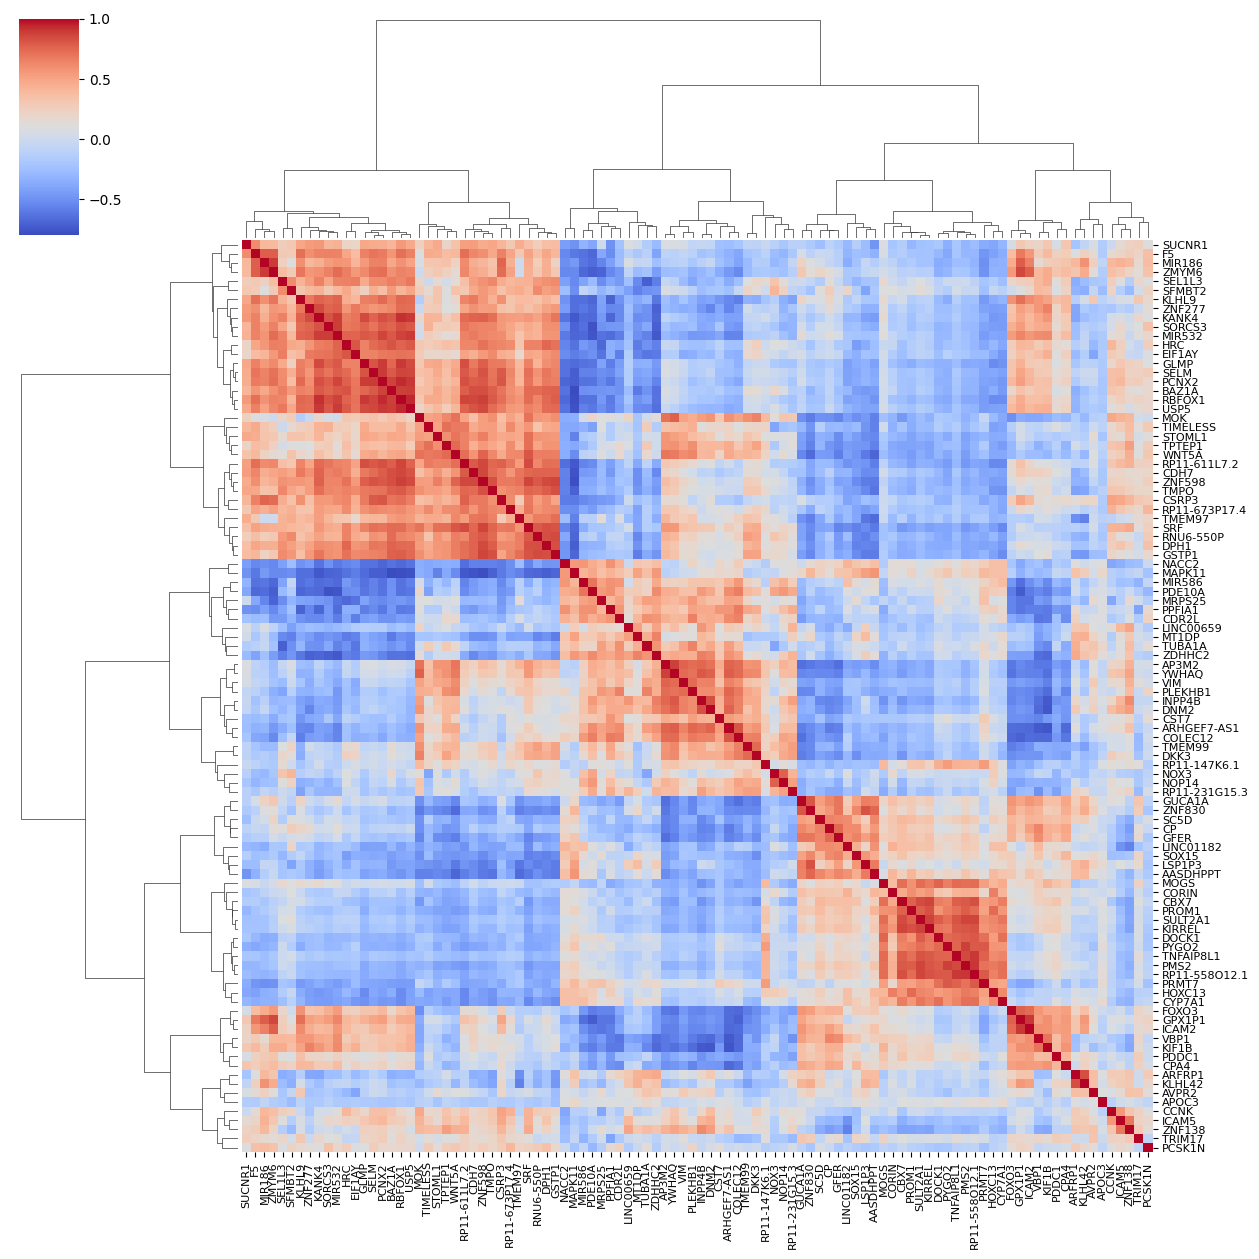

In [9]:
plot_clustermap(general_results[0], gene_names)

# 3. Clustering

In [10]:
# reset index
gene_names = gene_names.reset_index(drop=True)

### Generate Graph using Networkx

In [11]:
general_clustering = calculate_coexpression_graph(general_results[0], gene_names, threshold=0.2)

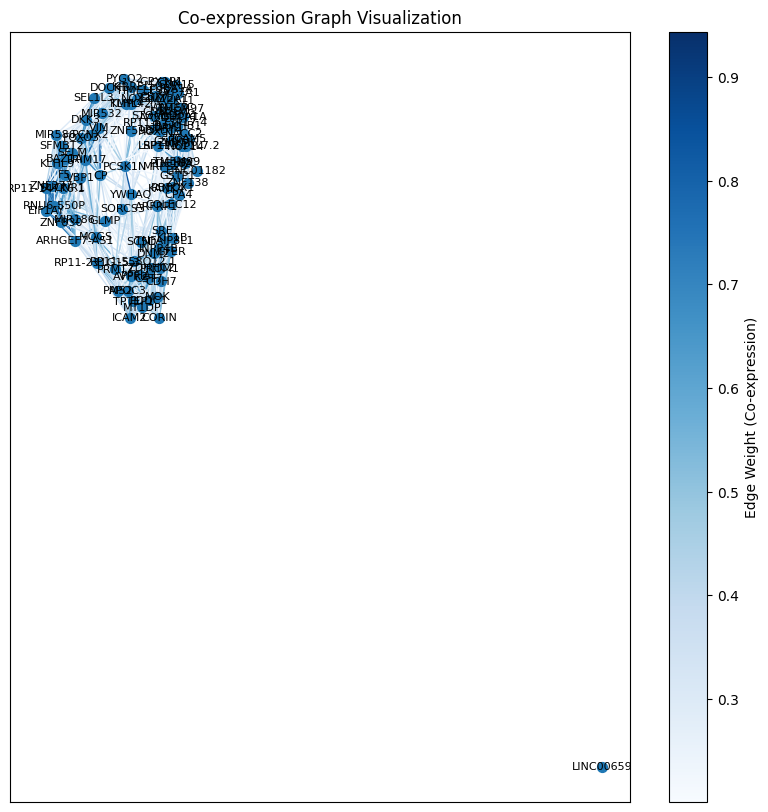

In [25]:
visualize_coexpression_graph(general_clustering)

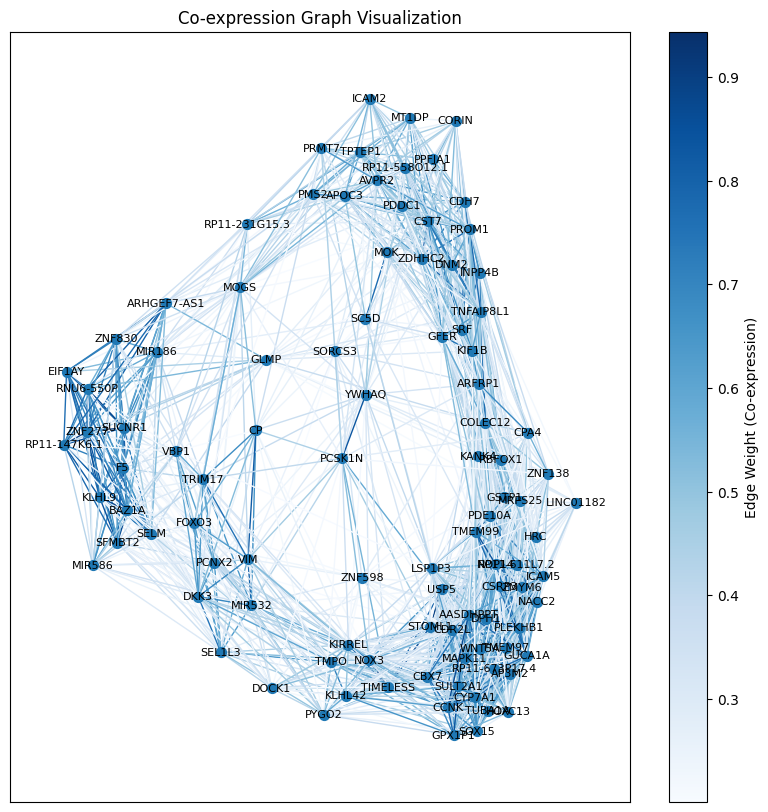

In [26]:
# handle outliers
general_clustering.remove_node('LINC00659')
visualize_coexpression_graph(general_clustering)

### Generate Gene Embeddings from Graph

In [12]:
# hyperparameters
dimensions = 32
n_clusters = 4
p = 1
q = 1

In [13]:
general_embedding = graph_to_node2vec_embeddings(general_clustering, dimensions=dimensions, p=p, q=q)

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 191.21it/s]


/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


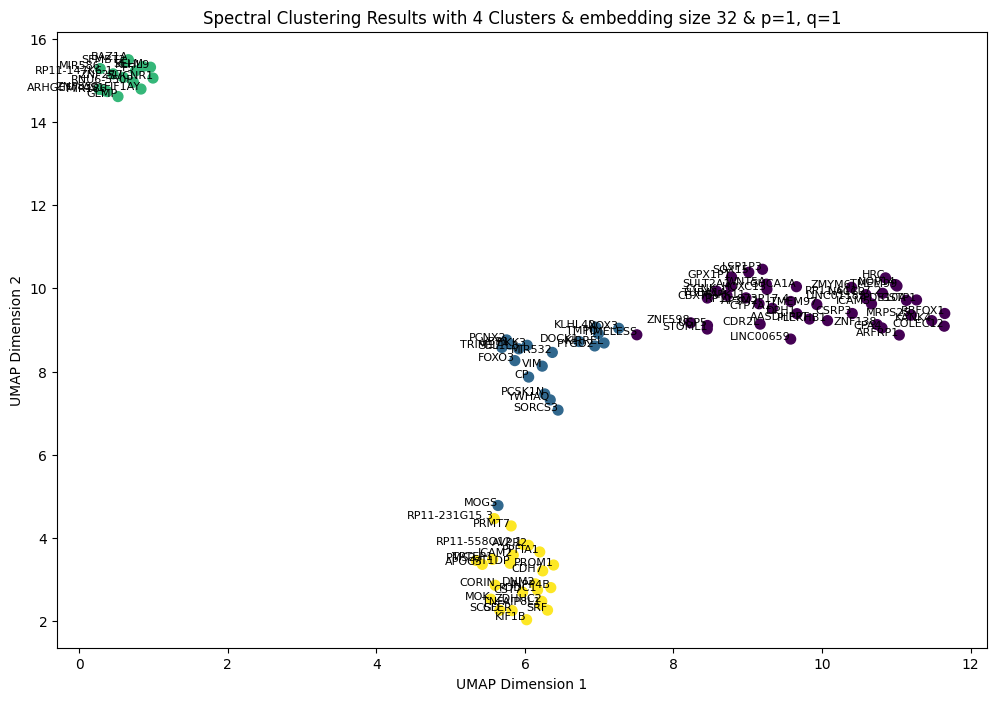

In [15]:
labels = plot_dendrogram_with_embeddings(
    general_embedding, gene_names.squeeze().tolist(), 
    dimensions, n_clusters=n_clusters, p=p, q=q
)

### Ablation Study for MGS_level

In [16]:
phase_1_clustering = calculate_coexpression_graph(phase_1_results[0], gene_names, threshold=0.2)
phase_2_clustering = calculate_coexpression_graph(phase_2_results[0], gene_names, threshold=0.2)
phase_3_clustering = calculate_coexpression_graph(phase_3_results[0], gene_names, threshold=0.2)
phase_4_clustering = calculate_coexpression_graph(phase_4_results[0], gene_names, threshold=0.2)

In [18]:
phase_1_embedding = graph_to_node2vec_embeddings(phase_1_clustering, dimensions=dimensions, p=p, q=q)
phase_2_embedding = graph_to_node2vec_embeddings(phase_2_clustering, dimensions=dimensions, p=p, q=q)
phase_3_embedding = graph_to_node2vec_embeddings(phase_3_clustering, dimensions=dimensions, p=p, q=q)
phase_4_embedding = graph_to_node2vec_embeddings(phase_4_clustering, dimensions=dimensions, p=p, q=q)

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 185.28it/s]


/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


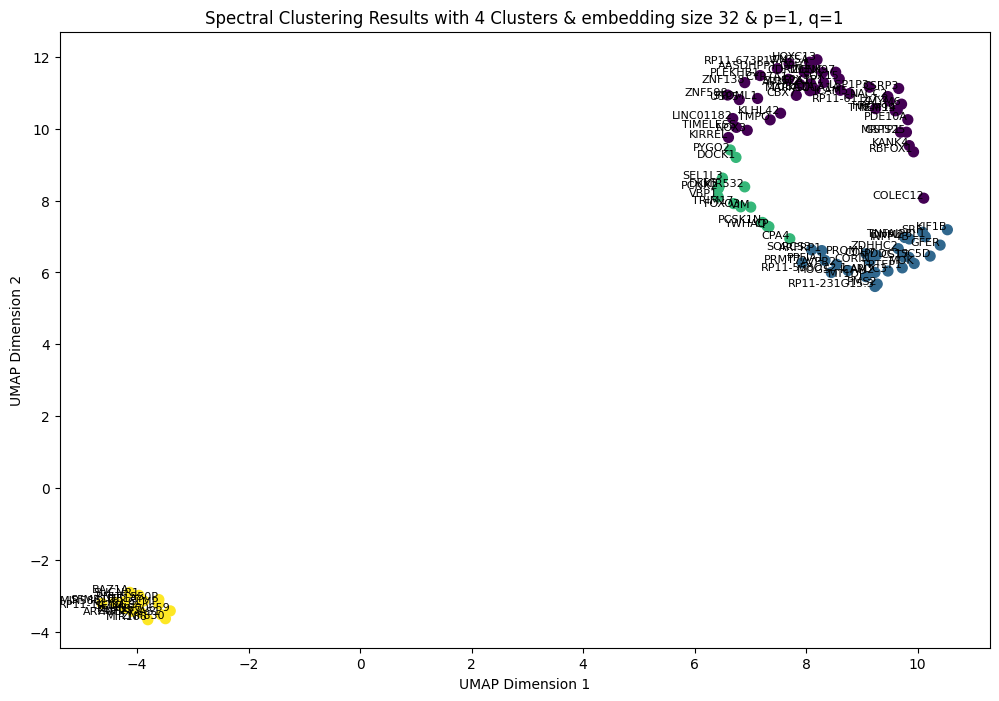

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


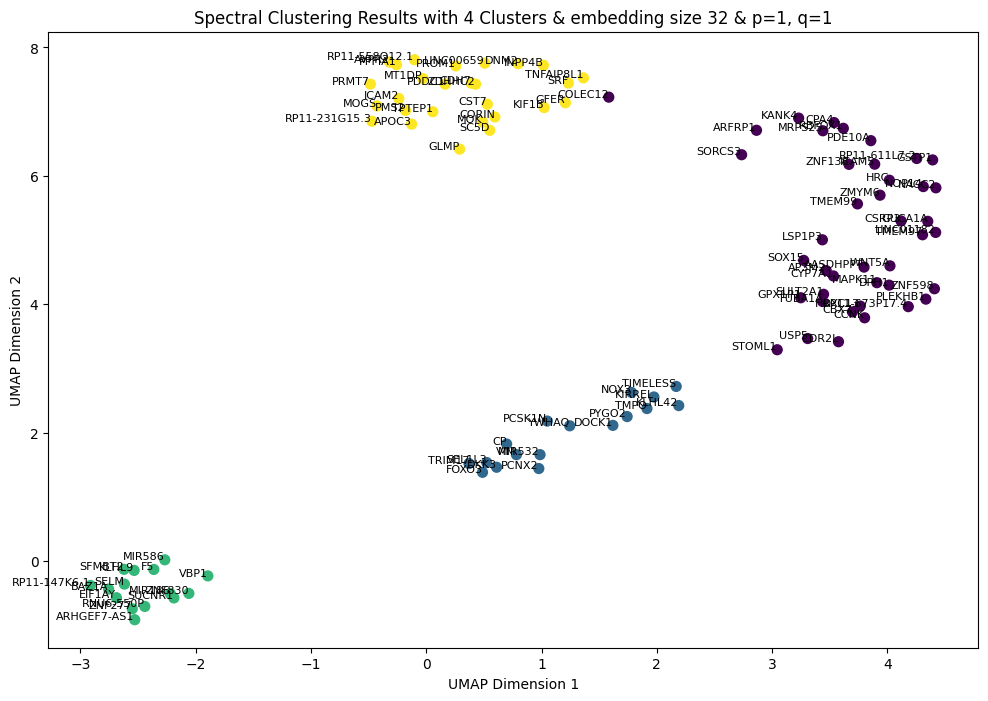

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


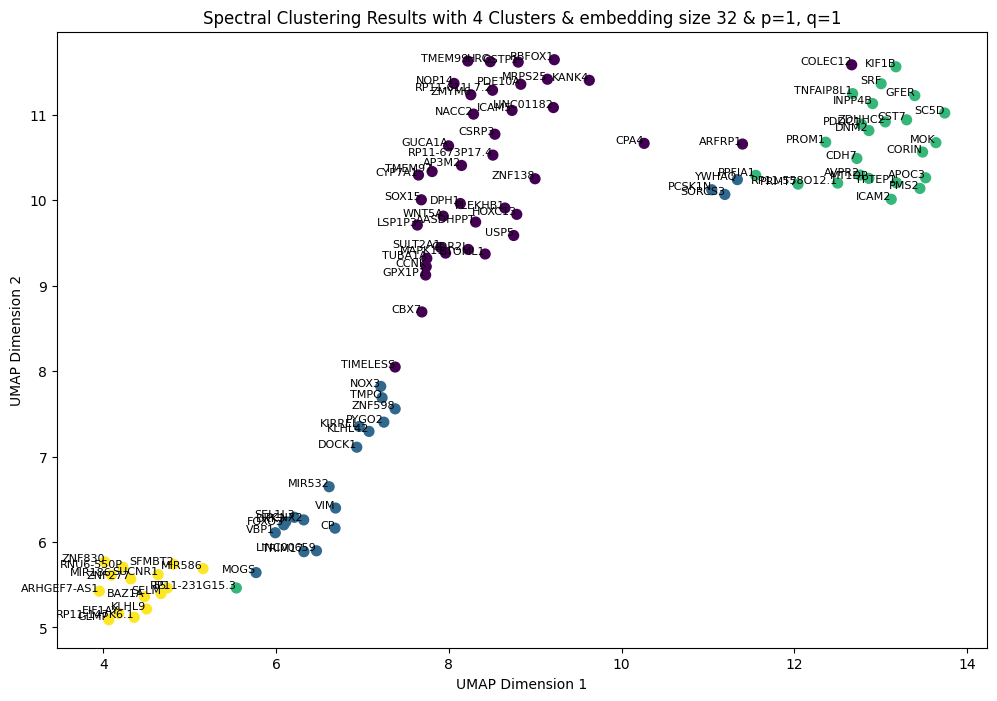

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


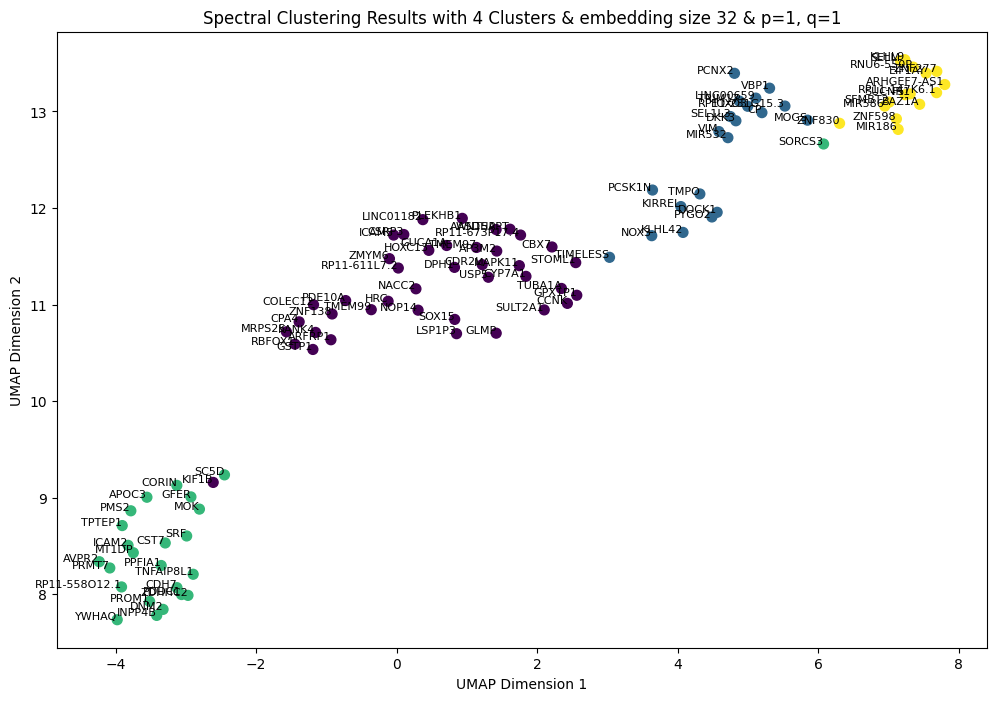

In [21]:
phase_1_labels = plot_dendrogram_with_embeddings(phase_1_embedding, gene_names.squeeze().tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)
phase_2_labels = plot_dendrogram_with_embeddings(phase_2_embedding, gene_names.squeeze().tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)
phase_3_labels = plot_dendrogram_with_embeddings(phase_3_embedding, gene_names.squeeze().tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)
phase_4_labels = plot_dendrogram_with_embeddings(phase_4_embedding, gene_names.squeeze().tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)

In [31]:
# analyze clusters from different phases
cluster_labels = pd.concat([
    pd.DataFrame(gene_names), 
    pd.DataFrame(labels),
    pd.DataFrame(phase_1_labels),
    pd.DataFrame(phase_2_labels),
    pd.DataFrame(phase_3_labels),
    pd.DataFrame(phase_4_labels)
], axis=1)
cluster_labels.columns = ['gene', 'general', 'phase_1', 'phase_2', 'phase_3', 'phase_4']

cluster_labels.to_csv('results/embedding_cluster_labels.csv', index=False)

In [30]:
cluster_labels

,gene,general,phase_1,phase_2,phase_3,phase_4
0,SUCNR1,2,3,2,3,3
1,F5,2,3,2,3,3
2,MIR186,2,3,2,3,3
3,ZMYM6,0,0,0,0,0
4,SEL1L3,1,2,1,1,1
...,...,...,...,...,...,...
95,CCNK,0,0,0,0,0
96,ICAM5,0,0,0,0,0
97,ZNF138,0,0,0,0,0
98,TRIM17,1,2,1,1,1
